### 1. Importing dependencies, utility functions and variables

In [380]:
import pandas as pd
import seaborn as sns
import numpy as np
import openpyxl
import tensorflow as tf
from window_generator import WindowGenerator
tf.random.set_seed(13)

This function defines early stopping during model fitting, as well as the loss function, the Adam optimizer and the two metrics desired to be tracked. 

In [383]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(), 
                         tf.keras.metrics.MeanAbsolutePercentageError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping],
                      verbose=0)
    return history

In [382]:
val_performance = {}
performance = {}

### 2. Reading the time series dataset and preprocessing

Get the date_time column and reformat it accordingly.

In [2]:
products = pd.read_excel("../../datasets/time_series_data/time_series_data.xlsx")
date_time = pd.to_datetime(products.pop('nota_data_emissao'), format='%Y%m%d')

Set the dataset index to be the dates.

In [3]:
products.index = date_time

For this forecasting we are considering the analysis over the <strong>B3</strong> product. So we filter it from the original dataset and sort by date.

In [4]:
b3 = products[products.produto_descricao == 'B3'].sort_values(by='nota_data_emissao', ascending=True)

Originally, we see there are days where there was no sample collected. We need to address this problem.

In [368]:
b3.head(5)

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao
nota_data_emissao,,,,
2020-10-01,B3,24,UN,3.19
2020-10-02,B3,24,UN,2.17
2020-10-02,B3,16,UN,3.19
2020-10-07,B3,1,UN,2.17
2020-10-07,B3,16,UN,2.17


Plotting the original time series, there are some ocasional patterns through the year but too unstable. This might be a problem.

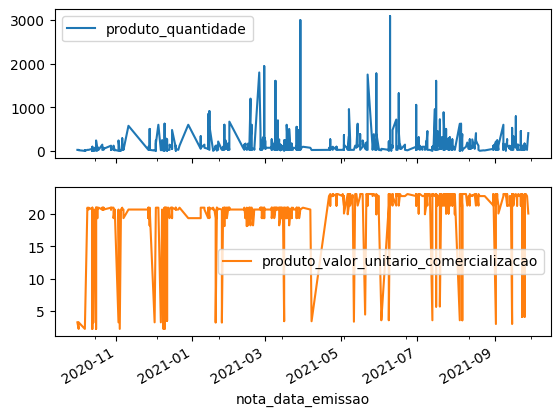

In [373]:
b3.plot(subplots=True)
plt.show()

This is the region where originally we can define somewhat of a pattern of variation in <strong>produto_quantidade</strong>.

array([<Axes: xlabel='nota_data_emissao'>,
       <Axes: xlabel='nota_data_emissao'>], dtype=object)

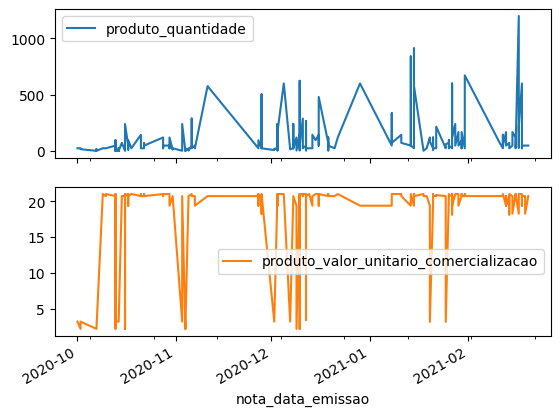

In [6]:
b3[:250].plot(subplots=True)

#### 2.1 Resampling by day as frequency and using interpolation to fill in the missing sample values

Now we have one single sample in the dataset for each day in the original time interval.

In [374]:
b3_resampled = b3.resample('D').mean(numeric_only=True)
b3_resampled = b3_resampled.interpolate()
b3_resampled

,produto_quantidade,produto_valor_unitario_comercializacao
nota_data_emissao,,
2020-10-01,24.00,3.19000
2020-10-02,20.00,2.68000
2020-10-03,17.00,2.57800
2020-10-04,14.00,2.47600
2020-10-05,11.00,2.37400
...,...,...
2021-09-24,24.00,22.81000
2021-09-25,81.25,20.39875
2021-09-26,120.00,23.13000


The instability has been addressed as the earlier resampling gets the mean for the set of multiple samples for the same day. As the dataset does not define hour, we cannot stablish a timeline for multiple daily samples. Interpolation also fills missing values and reduces discontinuity.  

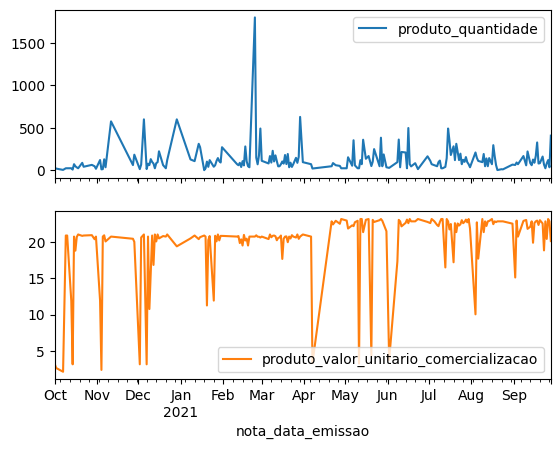

In [376]:
b3_resampled.plot(subplots=True)
plt.show()

#### 2.2 Split the data no shuffle

In [13]:
column_indices = {name: i for i, name in enumerate(b3_resampled.columns)}
column_indices

{'produto_quantidade': 0, 'produto_valor_unitario_comercializacao': 1}

Define the training set as 70% of the dataset, validation as 20% and test set as 10% of the original dataset.

In [14]:
n = len(b3_resampled)
train_b3 = b3_resampled[0:int(n*0.7)]
val_b3 = b3_resampled[int(n*0.7):int(n*0.9)]
test_b3 = b3_resampled[int(n*0.9):]

num_features = b3_resampled.shape[1]

#### 2.3 Normalizing the data using mean and std
Calculating mean and standard deviation only using the training data. The model should not access values from neither validation nor test sets! 

In [15]:
train_mean = train_b3.mean()
train_std = train_b3.std()

train_b3 = (train_b3 - train_mean) / train_std
val_b3 = (val_b3 - train_mean) / train_std
test_b3 = (test_b3 - train_mean) / train_std

In [378]:
train_b3.sample(5)

,produto_quantidade,produto_valor_unitario_comercializacao
nota_data_emissao,,
2021-03-16,-0.252948,-0.206916
2021-02-14,-0.590141,0.313845
2021-02-04,0.239159,0.399372
2021-01-24,-0.440086,-0.742205
2021-06-11,0.325712,0.659297


#### 2.4 Data windowing...

For this forecast model, we are using the WindowGenerator class. I adapted it from the <strong>TensorFlow's tutorial</strong> as it is really helpful for this project. 

This window here has 6 input samples (days) and shows one label (one day) regarding the 'produto_quantidade'.

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
               train_df=train_b3, val_df=val_b3, test_df=test_b3,
               label_columns=['produto_quantidade'])

In [ ]:
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['produto_quantidade']

In [21]:
example_window = tf.stack([np.array(train_b3[:w2.total_window_size]),
                           np.array(train_b3[50:50+w2.total_window_size]),
                           np.array(train_b3[100:100+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 2)
Inputs shape: (3, 6, 2)
Labels shape: (3, 1, 1)


These are three examples of windows with their inputs and labels splitted.

In [22]:
w2._example = example_inputs, example_labels

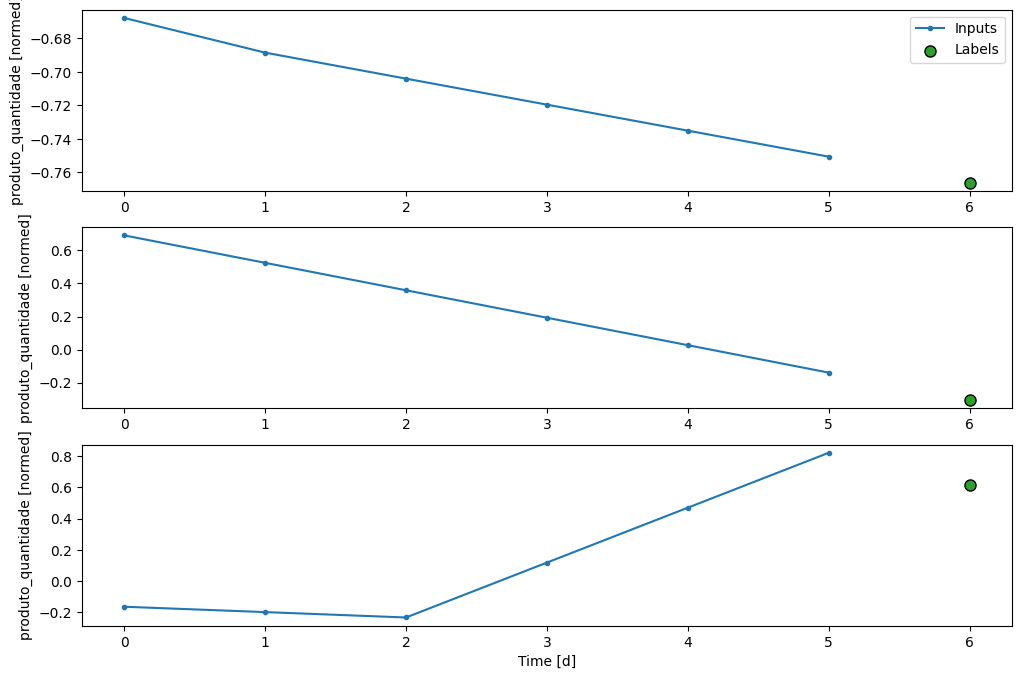

In [23]:
w2.plot(plot_col='produto_quantidade')

### 3. Training different neural networks for forecasting

We are considering MAPE as a satisficing metric where MAPE < 50% is considered satisfactory. The evaluation metric is taken care by RMSE.

It is important to highlight as well that we are trying to forecast <strong>produto_quantidade</strong> 4 times considering an interval of days. In other words, we are trying to forecast the amount of <strong>B3</strong> products in stock four times day by day.

#### 3.1 Linear single step model

This is the simplest NN with only one Dense layer and one unit. In this strategy, the model tries to learn only from the features from current time. There is no history it can learn from . We expect the results to be overfitted and perform poorly over test set.

In [26]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1,
               train_df=train_b3, val_df=val_b3, test_df=test_b3,
               label_columns=['produto_quantidade'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['produto_quantidade']

In [379]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (4, 1, 2)
Labels shape (batch, time, features): (4, 1, 1)


##### Defining the linear model

In [28]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

RMSE looks interesting on the validation set, but MAPE does not satisfy the requirements of being less than 50% on validation.

In [384]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

18/18 [==============================] - 0s 1ms/step - loss: 0.2669 - root_mean_squared_error: 0.5166 - mean_absolute_percentage_error: 126.7182


Using a wider window to visualize more forecastings.

In [33]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1,
               train_df=train_b3, val_df=val_b3, test_df=test_b3,
               label_columns=['produto_quantidade'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['produto_quantidade']

These results over the training data show us some tendendy in the forecast but still suffers to fit the data well only learning from current time.

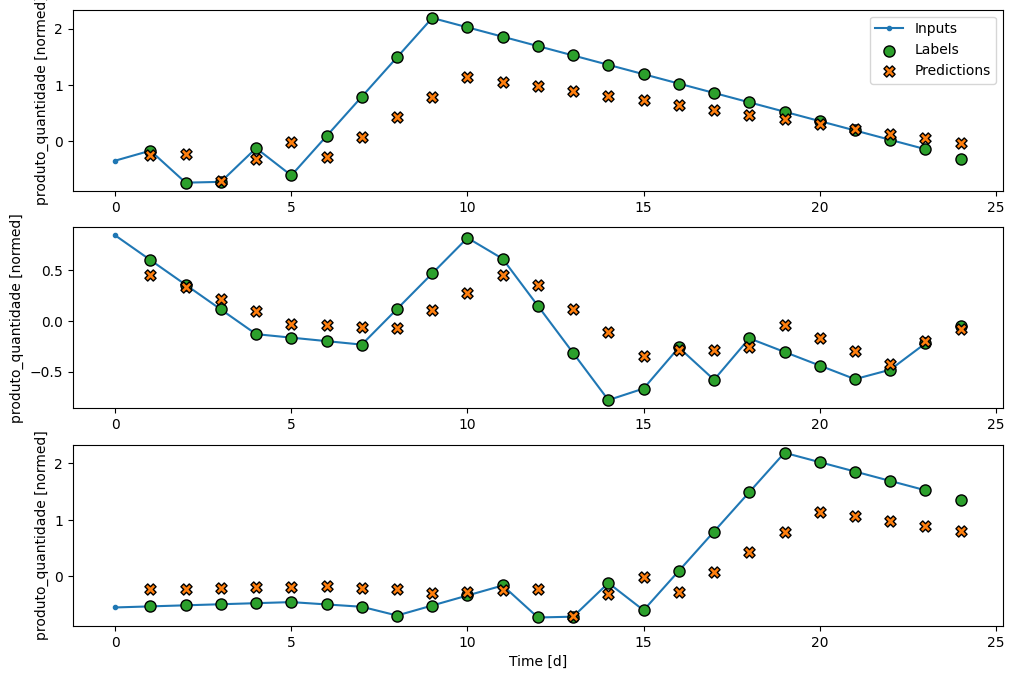

In [34]:
wide_window.plot(plot_col='produto_quantidade', model=linear)

#### 3.2 Deep single step model

Now let's consider this model defined using the Sequential API with further layers with more units. This should increase the complexity of the model and thus address underfitting on the training data.

Even though RMSE looks promising in the validation set, MAPE for this deeper model still does not satisfy requirements for validation.

In [385]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

18/18 [==============================] - 0s 1ms/step - loss: 0.2658 - root_mean_squared_error: 0.5155 - mean_absolute_percentage_error: 141.5079


For the training set, this visualization shows that underfitting is indeed addressed and we can see improvements.

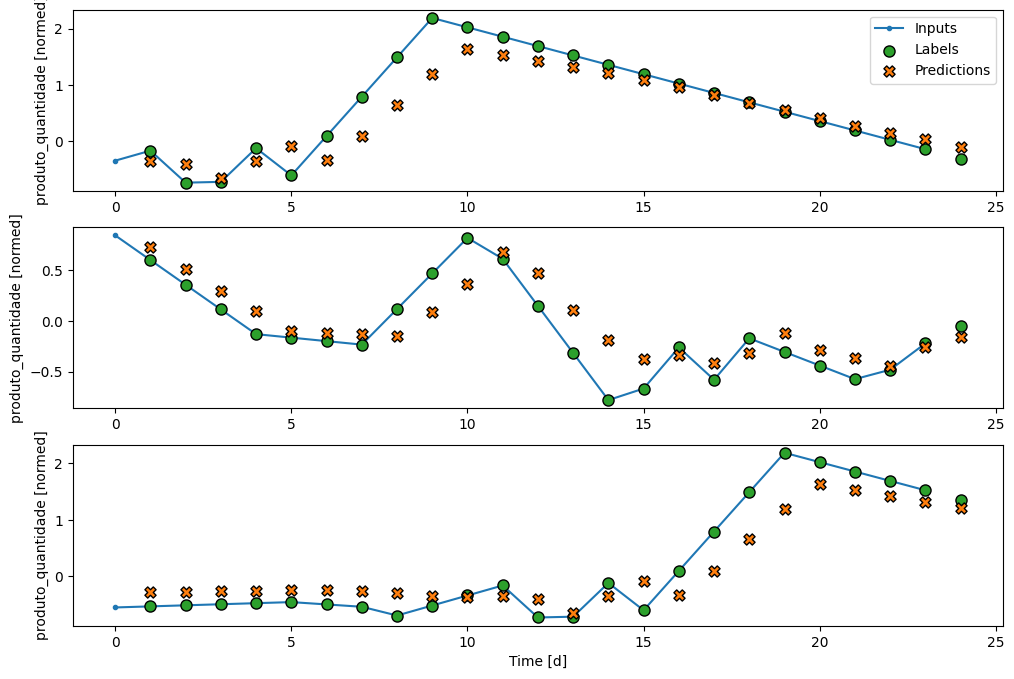

In [36]:
wide_window.plot(plot_col='produto_quantidade', model=dense)

#### 3.3 Convolutional multi-step model

This model is able to work with time history for learning. This 'conv_window' now carries a history of 31 (monthly) input features, 31 days of data so that we can forecast the value for <strong>produto_quantidade</strong> 1 day in the future.

In [326]:
CONV_WIDTH = 31
conv_window = WindowGenerator(input_width=CONV_WIDTH, label_width=1, shift=1,
               train_df=train_b3, val_df=val_b3, test_df=test_b3,
               label_columns=['produto_quantidade'])

conv_window

Total window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Label indices: [31]
Label column name(s): ['produto_quantidade']

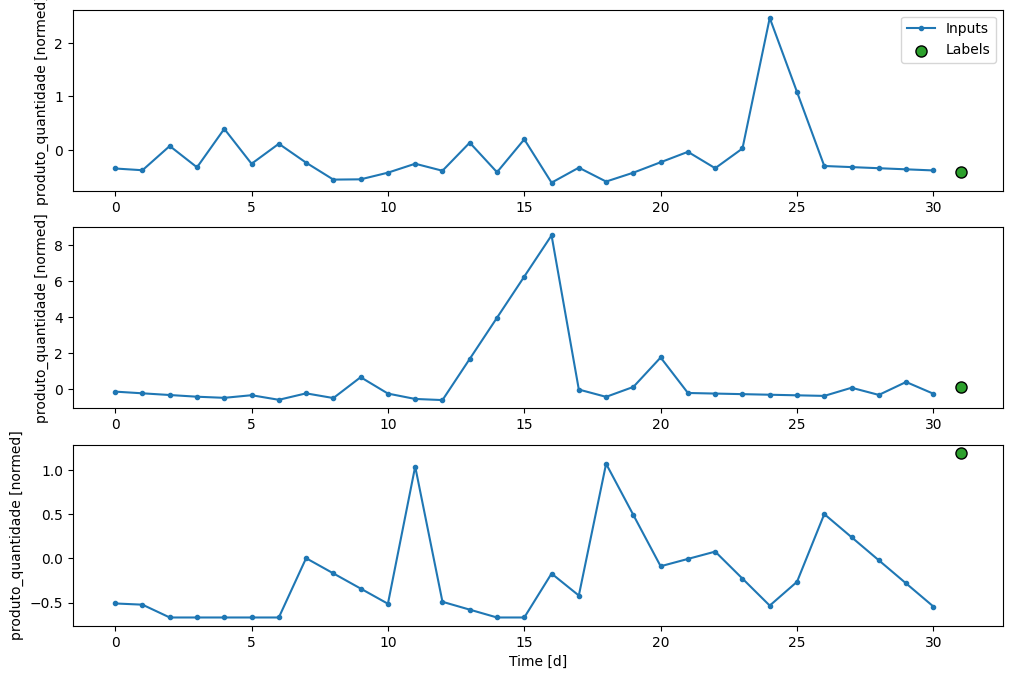

In [327]:
conv_window.plot(plot_col='produto_quantidade')

Defining the convolutional neural network using the Sequential API and adding a Dropout layer in order to prevent overfitting.

In [357]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dropout((0.1)),
    tf.keras.layers.Dense(units=1),
])

In [358]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (4, 31, 2)
Output shape: (4, 1, 1)


The results here show some stationary behaviour for RMSE compared to the previous models and still high MAPE for validation set.

In [386]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

11/11 [==============================] - 0s 1ms/step - loss: 0.2722 - root_mean_squared_error: 0.5217 - mean_absolute_percentage_error: 256.2514


This wider window here can show how this model forecast on training data 4 unit times in the future (4 daily predictions). It seems to address underfitting quite well compared to the previous models. Learning from history might show improvements. Let's see how it performs over test data finally.

In [387]:
LABEL_WIDTH = 4
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1,
               train_df=train_b3, val_df=val_b3, test_df=test_b3,
               label_columns=['produto_quantidade'])

wide_conv_window

Total window size: 35
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Label indices: [31 32 33 34]
Label column name(s): ['produto_quantidade']

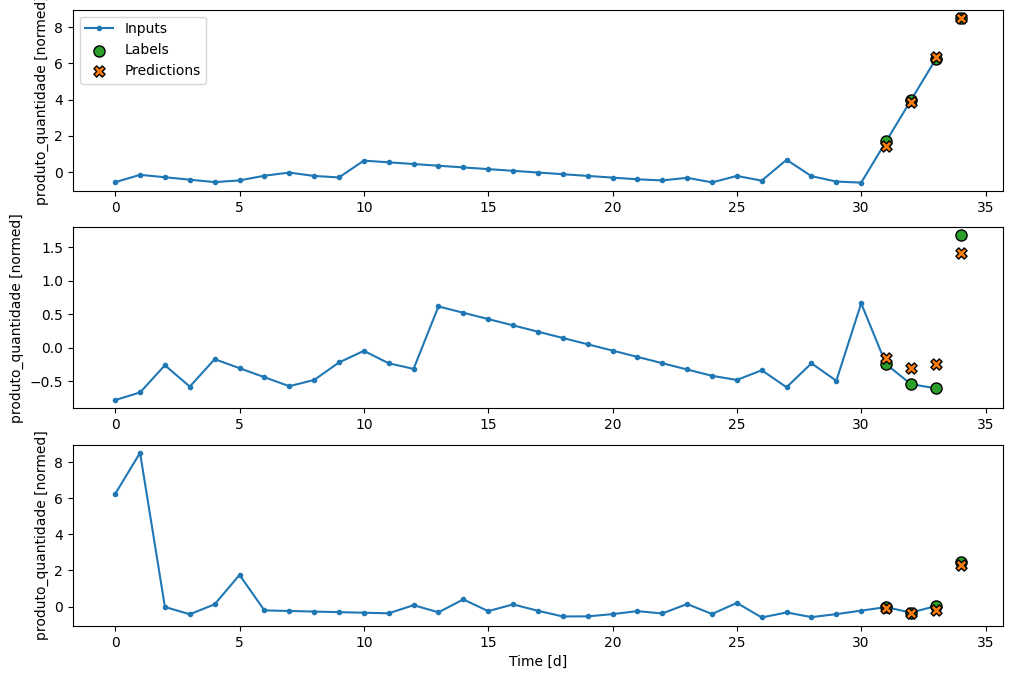

In [388]:
wide_conv_window.plot(plot_col='produto_quantidade', model=conv_model)

In [424]:
print(val_performance)

{'Linear': [0.26692572236061096, 0.516648530960083, 126.7182388305664], 'Dense': [0.2657864987850189, 0.5155448317527771, 141.50790405273438], 'Conv': [0.27218911051750183, 0.5217174887657166, 256.25140380859375]}


In [454]:
test = pd.DataFrame(performance).transpose()
test['dataset'] = 'test'
test.columns = ['loss', 'RMSE', 'MAPE', 'dataset']

val = pd.DataFrame(val_performance).transpose()
val['dataset'] = 'val'
val.columns = ['loss', 'RMSE', 'MAPE', 'dataset']

In [455]:
results = pd.concat([test, val], axis=0).reset_index().rename(columns={'index': 'model'})

In [456]:
results

,model,loss,RMSE,MAPE,dataset
0,Linear,0.194415,0.440925,2852.339600,test
1,Dense,0.176958,0.420664,1961.923828,test
2,Conv,0.529020,0.727337,49.164089,test
3,Linear,0.266926,0.516649,126.718239,val
4,Dense,0.265786,0.515545,141.507904,val
5,Conv,0.272189,0.521717,256.251404,val


These results show that only the convolutional model satisfies the requirements of having less than 50% on MAPE. Even though the RMSE for test set on the convolutional model is higher compared to the others, this is the one chosen.

<Axes: xlabel='model', ylabel='MAPE'>

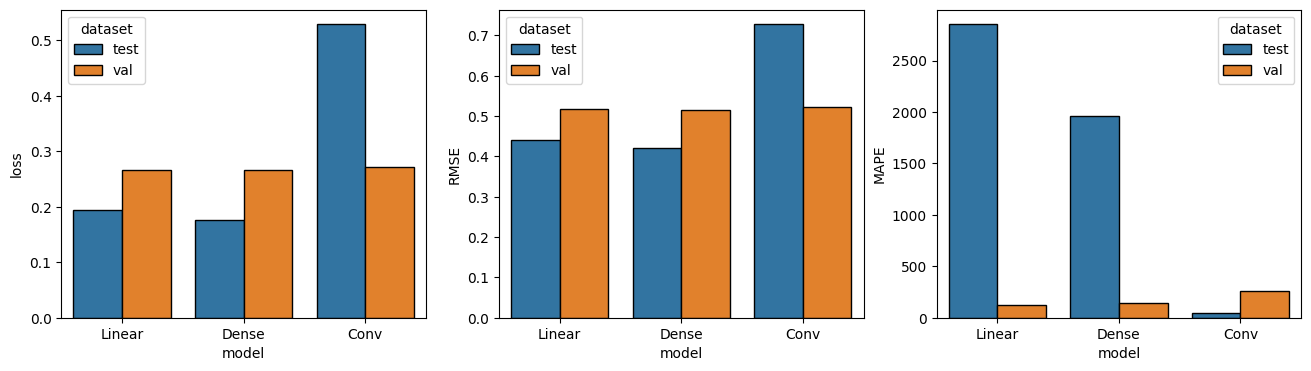

In [458]:
fig, ax = plt.subplots(ncols=3, figsize=(16,4))
sns.barplot(data=results, x='model', y='loss', hue='dataset', edgecolor='black', ax=ax[0])
sns.barplot(data=results, x='model', y='RMSE', hue='dataset', edgecolor='black', ax=ax[1])
sns.barplot(data=results, x='model', y='MAPE', hue='dataset', edgecolor='black', ax=ax[2])

In [391]:
conv_model.evaluate(conv_window.test)

2/2 [==============================] - 0s 4ms/step - loss: 0.5290 - root_mean_squared_error: 0.7273 - mean_absolute_percentage_error: 49.1641


[0.5290195345878601, 0.7273373007774353, 49.16408157348633]

### 4. Forecasting on the test set defined earlier in this notebook.

We can see the model follows a certain tendency while forecasting and understanding moments of decrease and increase in <strong>B3</strong> stock. 

When visualizing <strong>produto_quantidade</strong> time series previously, the seasonality seemed to occur roughly ever two months, approximately 60 days. This window of time was considered when trying to train the convolutional model and it indeed fitted better the training data. But the lack of data in the test set (37 samples after resample) made not possible to evaluate performance and check for model fitness. 

In [392]:
example_window_2 = tf.stack([np.array(test_b3[:wide_conv_window.total_window_size])])

example_inputs, example_labels = wide_conv_window.split_window(example_window_2)

In [393]:
wide_conv_window._example = example_inputs, example_labels

Considering the test set has 37 daily samples, the plot below forecasts the <strong>B3</strong> stock on day 32 based on the previous 31 days defined in the window. Days 33, 34 and 35 are forecasted similarly.

In [459]:
print(test_b3.shape)

(37, 2)


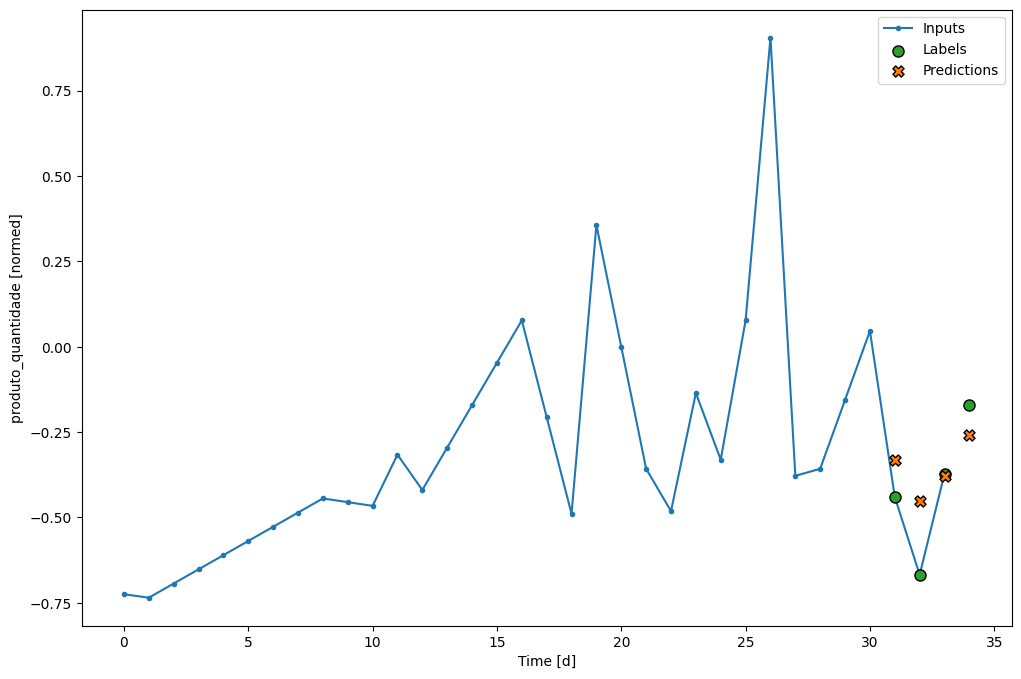

In [394]:
wide_conv_window.plot(plot_col='produto_quantidade', model=conv_model)